In [29]:
library(tidyverse)
library(umap)

# Custom package
library(rutils)

In [30]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [31]:
dset_idx <- 2

In [32]:
matrisome_df <- load_matrisome_df(matrisome_path)

Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)


In [33]:
seed = 123

# Load and filter survival data

In [34]:
event_code <- list("Alive" = 0, "Dead" = 1)
covariate_cols <- c("figo_stage", "age_at_diagnosis", "race", "ethnicity")
dep_cols <- c("vital_status", "survival_time")
figo_map_df <- tibble(
    roman_num = c("I", "II", "III", "IV"),
    figo_code = c('1', '2', '3', '4')
)

In [35]:
# survival_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[i], "/survival_data.tsv"))
survival_path <- paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/survival_data.tsv")
survival_df <- load_survival_df(survival_path, event_code)
filtered_survival_df <- survival_df %>%
    dplyr::select(one_of(c("sample_name", dep_cols, covariate_cols))) %>%
    dplyr::filter(rowSums(is.na(.)) == 0) %>%
    dplyr::mutate(
        figo_rn = str_extract(figo_stage, "IV|III|II|I")
    ) %>%
    dplyr::inner_join(figo_map_df, by = c("figo_rn" = "roman_num")) %>%
    dplyr::select(-c(figo_rn, figo_stage)) %>%
    dplyr::rename(figo_stage = figo_code) %>%
    bind_cols(to_one_hot(., "race")) %>%
    bind_cols(to_one_hot(., "ethnicity")) %>%
    bind_cols(to_one_hot(., "figo_stage"))

Parsed with column specification:
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  survival_time = col_double(),
  figo_stage = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race = col_character(),
  ethnicity = col_character()
)


# Load normalized matrisome count data

In [36]:
norm_matrisome_counts <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/norm_matrisome_counts.tsv")) %>%
    column_to_rownames(var = "geneID") %>%
    as.matrix()

# Match up columns of counts with rows of survival data & only include samples present in survival data
norm_matrisome_survival_counts <- norm_matrisome_counts[, filtered_survival_df$sample_name]

Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character()
)
See spec(...) for full column specifications.


In [37]:
all(rownames(t(norm_matrisome_survival_counts)) == filtered_survival_df$sample_name)

[1] TRUE

# Load normalized count data (for all genes)

In [38]:
norm_counts <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/norm_counts.tsv")) %>%
    column_to_rownames(var = "geneID") %>%
    as.matrix()

# Match up columns of counts with rows of survival data & only include samples present in survival data
norm_survival_counts <- norm_counts[, filtered_survival_df$sample_name]

Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character()
)
See spec(...) for full column specifications.


In [39]:
all(rownames(t(norm_survival_counts)) == filtered_survival_df$sample_name)

[1] TRUE

# Combine filtered survival data and normalized count data

In [40]:
joined_matrisome_df <- filtered_survival_df %>%
    inner_join(
        as_tibble(t(norm_matrisome_survival_counts), rownames = "sample_name"),
        by = "sample_name"
    )

# Some genes contain the '-' symbol, which affects formulae
colnames(joined_matrisome_df) <- gsub("-", "_", colnames(joined_matrisome_df))

In [41]:
joined_full_df <- filtered_survival_df %>%
    inner_join(
        as_tibble(t(norm_survival_counts), rownames = "sample_name"),
        by = "sample_name"
    )

# Some genes contain the '-' symbol, which affects formulae
colnames(joined_full_df) <- gsub("-", "_", colnames(joined_full_df))

In [42]:
nrow(joined_full_df)

[1] 46

# Helper functions

In [43]:
to_deceased_df <- function(df) {
    deceased_joined_df <- df %>%
        dplyr::filter(vital_status == 1) %>%
        dplyr::select(-vital_status)
    
    quantiles <- as.vector(quantile(deceased_joined_df$survival_time))
    iqr <- quantiles[4] - quantiles[2]
    coef <- 1.5
    outlier_thresh <- list(min = quantiles[2] - coef * iqr, max = quantiles[4] + coef * iqr)
    
    deceased_joined_df <- deceased_joined_df %>%
        dplyr::mutate(observation_type = case_when(
            ((survival_time < outlier_thresh$min) | (outlier_thresh$max < survival_time)) ~ "outlier",
            ((outlier_thresh$min < survival_time) & (survival_time < outlier_thresh$max)) ~ "regular"
        )) %>%
        dplyr::mutate(survival_class = case_when(
            (survival_time < quantiles[2]) ~ "low",
            (quantiles[2] <= survival_time) & (survival_time < quantiles[3]) ~ "low_med",
            (quantiles[3] <= survival_time) & (survival_time < quantiles[4]) ~ "high_med",
            (quantiles[4] <= survival_time) ~ "high"
        )) %>%
        dplyr::mutate(survival_class = factor(survival_class, levels = c("low", "low_med", "high_med", "high"))) %>%
        dplyr::select(c("sample_name", "survival_time", "survival_class"), everything())    
    return(deceased_joined_df)
}


to_figo_df <- function(df) {
    figo_joined_df <- df %>%
        # Drop the original character versions of these columns
        dplyr::select(c("sample_name", "figo_stage"), everything(), -c("survival_time","race", "ethnicity", "vital_status")) %>%
        dplyr::select(-contains("figo_stage_")) %>%
        dplyr::mutate(figo_stage = factor(figo_stage, levels = c("1", "2", "3", "4")))
    return(figo_joined_df)
}


summarize_deceased <- function(df) {
    df %>%
        group_by(figo_stage) %>%
        summarize(
            n = n(),
            mean_survival = mean(survival_time) / 365,
            median_survival = median(survival_time) / 365,
            survival_iqr = IQR(survival_time / 365),
            min_survival = min(survival_time) / 365,
            max_survival = max(survival_time) / 365
        )
}


umap_to_df <- function(umap_res, processed_df, dep_cols) {
    colnames(umap_res$layout) <- c("x1", "x2")
    umap_df <- umap_res$layout %>%
        as_tibble() %>%
        bind_cols(processed_df[all_of(dep_cols)]) %>%
        dplyr::select(all_of(dep_cols), everything())
    return(umap_df)
}

In [44]:
deceased_full_df <- to_deceased_df(joined_full_df)
deceased_matrisome_df <- to_deceased_df(joined_matrisome_df)

In [45]:
nrow(deceased_matrisome_df)

[1] 27

In [46]:
nrow(deceased_matrisome_df %>%
    dplyr::filter(observation_type == "outlier"))

[1] 3

In [47]:
summarize_deceased(deceased_full_df)

`summarise()` ungrouping output (override with `.groups` argument)


figo_stage,n,mean_survival,median_survival,survival_iqr,min_survival,max_survival
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,2.241781,1.287671,1.3047945,0.000000000,8.534247
2,2,2.809589,2.809589,2.7876712,0.021917808,5.597260
3,14,1.865558,1.231507,1.3821918,0.002739726,7.342466
4,3,1.389041,1.482192,0.9534247,0.389041096,2.295890


In [48]:
# options(repr.plot.width = 10, repr.plot.height = 5)
# ggplot(data=deceased_full_df) +
#     geom_point(aes(x = seq(1, nrow(deceased_full_df)), y = survival_time, color=observation_type))
# ggplot(data=deceased_full_df) +
#     geom_point(aes(x = seq(1, nrow(deceased_full_df)), y = survival_time, color=figo_stage))
# options(repr.plot.width = 15, repr.plot.height = 5)
# ggplot() +
#     geom_point(data = deceased_full_df, aes(x = age_at_diagnosis, y = log(survival_time), color=observation_type)) +
#     geom_smooth(
#         data = deceased_full_df %>% dplyr::filter(observation_type == "regular"),
#         aes(x = age_at_diagnosis, y = log(survival_time), color = "fit"),
#         method = "lm",
#         formula = y ~ x,
#         color = "black",
#         size = 0.4
#     )
# options(repr.plot.width = 10, repr.plot.height = 5)
# ggplot(data=deceased_full_df) +
#     geom_violin(aes(x = survival_time, y = figo_stage, color = figo_stage)) +
#     geom_boxplot(aes(x = survival_time, y = figo_stage, color = figo_stage), width = 0.2)
# ggplot() +
#     geom_density(data = deceased_full_df, aes(x = survival_time), color = "black") +
#     geom_density(
#         data = deceased_full_df %>% dplyr::filter(observation_type == "regular"),
#         aes(x = survival_time),
#         color = "#00BFC4"
#     )

In [49]:
processed_deceased_full_df <- deceased_full_df %>%
    dplyr::select(c("sample_name", "survival_class"), everything(), -c("survival_time", "race", "ethnicity", "figo_stage", "observation_type"))
processed_deceased_matrisome_df <- deceased_matrisome_df %>%
    dplyr::select(c("sample_name", "survival_class"), everything(), -c("survival_time", "race", "ethnicity", "figo_stage", "observation_type"))

In [50]:
full_survival_umap <- umap(processed_deceased_full_df[-c(1, 2)], random_state = seed)
matrisome_survival_umap <- umap(processed_deceased_matrisome_df[-c(1, 2)], random_state = seed)

In [51]:
survival_full_umap_df <- umap_to_df(full_survival_umap, processed_deceased_full_df, c("sample_name", "survival_class"))
survival_matrisome_umap_df <- umap_to_df(matrisome_survival_umap, processed_deceased_matrisome_df, c("sample_name", "survival_class"))

In [52]:
# plt <- ggplot(survival_full_umap_df) +
#     geom_point(aes(x = x1, y = x2, color = survival_class)) +
#     theme_classic()
# plt

# plt <- ggplot(survival_matrisome_umap_df) +
#     geom_point(aes(x = x1, y = x2, color = survival_class)) +
#     theme_classic()
# plt

In [53]:
figo_full_df <- to_figo_df(joined_full_df)
figo_matrisome_df <- to_figo_df(joined_matrisome_df)

In [54]:
full_figo_umap <- umap(figo_full_df[-c(1, 2)], random_state = seed)
matrisome_figo_umap <- umap(figo_matrisome_df[-c(1, 2)], random_state = seed)

In [55]:
full_figo_umap_df <- umap_to_df(full_figo_umap, figo_full_df, c("sample_name", "figo_stage"))
matrisome_figo_umap_df <- umap_to_df(matrisome_figo_umap, figo_matrisome_df, c("sample_name", "figo_stage"))

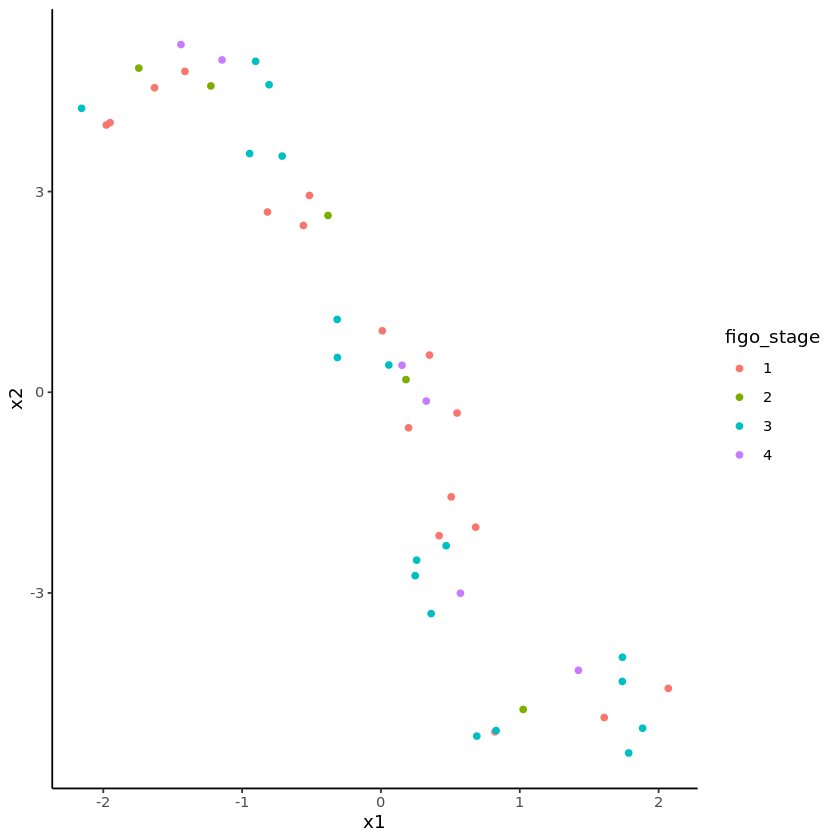

In [56]:
# plt <- ggplot(full_figo_umap_df) +
#     geom_point(aes(x = x1, y = x2, color = figo_stage)) +
#     theme_classic()
# plt

plt <- ggplot(matrisome_figo_umap_df) +
    geom_point(aes(x = x1, y = x2, color = figo_stage)) +
    theme_classic()
plt